In [6]:
import numpy as np
from joblib import load
import matplotlib.pyplot as plt

data_base = "final_evaluation_data/"
data_regular_food = "regular_food_2/"

prediction_models = "prediction_models/models/"
screens_base = "final_evaluation_screens/"



In [7]:
def reshape_and_mean(data):
    return data.reshape(-1, 2, 19).mean(axis=1)

In [8]:
UV_x = np.loadtxt(data_base + data_regular_food + "UV.csv", delimiter='|')
VIS_x = np.loadtxt(data_base + data_regular_food + "VIS.csv", delimiter='|')
IR_x = np.loadtxt(data_base + data_regular_food + "IR.csv", delimiter='|')

UV_x = reshape_and_mean(UV_x)
VIS_x = reshape_and_mean(VIS_x)
IR_x = reshape_and_mean(IR_x)

# Final Evaluation

4.8 mmol/L at the beginning

30 minutes of measurements, 1 per minute

Started fasted and at 10th minute began eating.

9.6 mmol/L at the end

## Linear regression

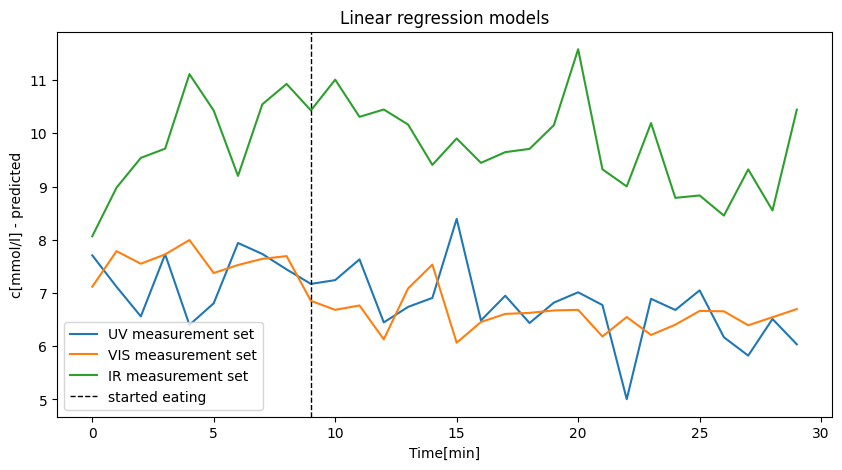

In [29]:

UV_linear_regression = load(prediction_models + "UV_linear_regr.joblib")
VIS_linear_regression = load(prediction_models + "VIS_linear_regr.joblib")
IR_linear_regression = load(prediction_models + "IR_linear_regr.joblib")

UV_indices = [0, 2, 3, 6, 7, 8, 10, 12]
VIS_indices = [0, 2, 5, 6, 8, 13, 14]
IR_indices = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 14, 15, 16, 18]

UV_predictions = UV_linear_regression.predict(UV_x[:, UV_indices])
VIS_predictions = VIS_linear_regression.predict(VIS_x[:, VIS_indices])
IR_predictions = IR_linear_regression.predict(IR_x[:, IR_indices])

plt.figure(figsize=(10, 5))
plt.title("Linear regression models")    

plt.xlabel("Time[min]")
plt.ylabel("c[mmol/l] - predicted")

plt.plot(UV_predictions, label="UV measurement set")
plt.plot(VIS_predictions, label="VIS measurement set")
plt.plot(IR_predictions, label="IR measurement set")

plt.axvline(9, linewidth=1, color='k', linestyle='--', label="started eating")

plt.legend()
    
plt.savefig(screens_base + 'linear_regr.png', bbox_inches='tight', pad_inches=0.1)
    
plt.show()


## Random forest

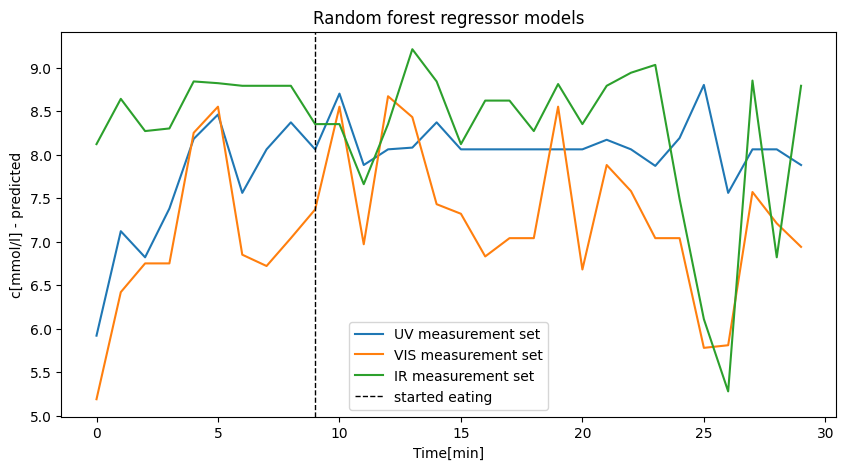

In [30]:
UV_random_forest = load(prediction_models + "UV_random_forest.joblib")
VIS_random_forest = load(prediction_models + "VIS_random_forest.joblib")
IR_random_forest = load(prediction_models + "IR_random_forest.joblib")

UV_indices = [0, 1, 2, 3, 4, 5, 6, 7, 13, 14, 15, 16, 18]
VIS_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
IR_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

UV_predictions = UV_random_forest.predict(UV_x[:, UV_indices])
VIS_predictions = VIS_random_forest.predict(VIS_x[:, VIS_indices])
IR_predictions = IR_random_forest.predict(IR_x[:, IR_indices])

plt.figure(figsize=(10, 5))
plt.title("Random forest regressor models")    

plt.xlabel("Time[min]")
plt.ylabel("c[mmol/l] - predicted")

plt.plot(UV_predictions, label="UV measurement set")
plt.plot(VIS_predictions, label="VIS measurement set")
plt.plot(IR_predictions, label="IR measurement set")

plt.axvline(9, linewidth=1, color='k', linestyle='--', label="started eating")

plt.legend()
    
plt.savefig(screens_base + 'random_forest.png', bbox_inches='tight', pad_inches=0.1)
    
plt.show()

In [9]:
from torch import nn
import torch

(h1, h2) = (1024, 512)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(19, h1),
            nn.Tanh(),
            nn.Linear(h1, h2),
            nn.Tanh(),
            nn.Linear(h2, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [27]:
UV_nn_model = MLP()
UV_nn_model.load_state_dict((torch.load(prediction_models + "UV_neural_network.pt")))
UV_nn_model.eval()

VIS_nn_model = MLP()
VIS_nn_model.load_state_dict((torch.load(prediction_models + "VIS_neural_network.pt")))
VIS_nn_model.eval()

IR_nn_model = MLP()
IR_nn_model.load_state_dict((torch.load(prediction_models + "IR_neural_network.pt")))
IR_nn_model.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=1024, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

## Neural Network

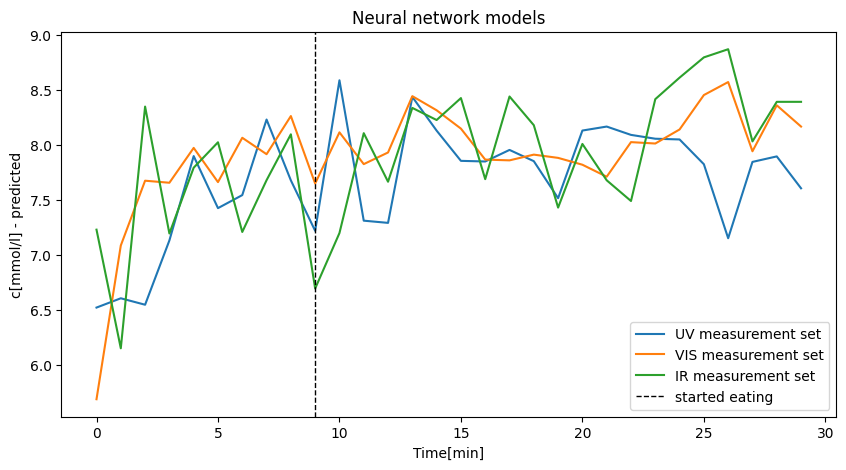

In [31]:
UV_scaler = load("scalers/UV_std_scaler.joblib")
VIS_scaler = load("scalers/VIS_std_scaler.joblib")
IR_scaler = load("scalers/IR_std_scaler.joblib")

UV_x_scaled = UV_scaler.transform(UV_x)
UV_x_scaled = torch.tensor(UV_x_scaled, dtype=torch.float32)

VIS_x_scaled = VIS_scaler.transform(VIS_x)
VIS_x_scaled = torch.tensor(VIS_x_scaled, dtype=torch.float32)

IR_x_scaled = IR_scaler.transform(IR_x)
IR_x_scaled = torch.tensor(IR_x_scaled, dtype=torch.float32)

UV_predictions = UV_nn_model(UV_x_scaled).detach().numpy()
VIS_predictions = VIS_nn_model(VIS_x_scaled).detach().numpy()
IR_predictions = IR_nn_model(IR_x_scaled).detach().numpy()

plt.figure(figsize=(10, 5))
plt.title("Neural network models")    

plt.xlabel("Time[min]")
plt.ylabel("c[mmol/l] - predicted")

plt.plot(UV_predictions, label="UV measurement set")
plt.plot(VIS_predictions, label="VIS measurement set")
plt.plot(IR_predictions, label="IR measurement set")

plt.axvline(9, linewidth=1, color='k', linestyle='--', label="started eating")

plt.legend()
    
plt.savefig(screens_base + 'neural_network.png', bbox_inches='tight', pad_inches=0.1)
    
plt.show()

In [10]:
from torch import nn
import torch

(h1, h2) = (1024, 512)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, h1),
            nn.Tanh(),
            nn.Linear(h1, h2),
            nn.Tanh(),
            nn.Linear(h2, 1)
        )

    def forward(self, x):
        return self.layers(x)

IR_nn_model = MLP()
IR_nn_model.load_state_dict((torch.load(prediction_models + "IR_neural_network_best_channels.pt")))
IR_nn_model.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

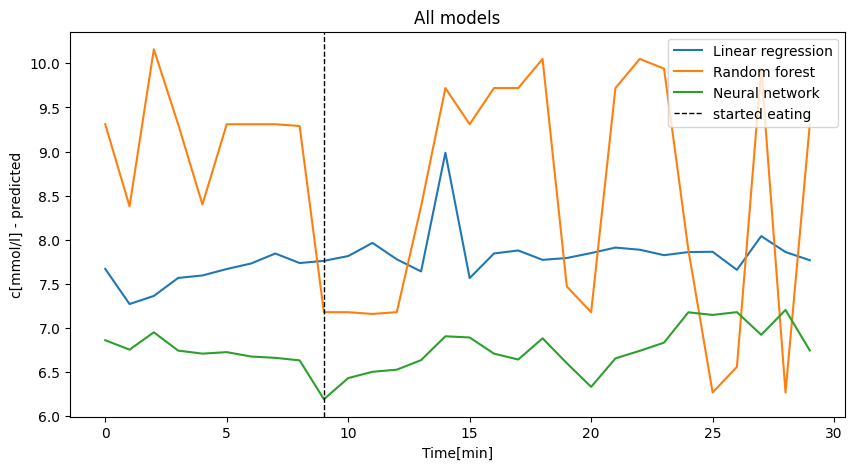

In [13]:
# Best channels in IR dataset

IR_indices = [10, 11, 16, 17]

IR_linear_regression = load(prediction_models + "IR_linear_regr_best_channels.joblib")
IR_random_forest = load(prediction_models + "IR_random_forest_best_channels.joblib")

IR_scaler = load("scalers/IR_std_scaler.joblib")

IR_x_scaled = IR_scaler.transform(IR_x)
IR_x_scaled = torch.tensor(IR_x_scaled, dtype=torch.float32)

IR_linreg_predictions = IR_linear_regression.predict(IR_x[:, IR_indices])
IR_randfor_predictions = IR_random_forest.predict(IR_x[:, IR_indices])
IR_nn_predictions = IR_nn_model(IR_x_scaled[:, IR_indices]).detach().numpy()

plt.figure(figsize=(10, 5))
plt.title("All models")    

plt.xlabel("Time[min]")
plt.ylabel("c[mmol/l] - predicted")

plt.plot(IR_linreg_predictions, label="Linear regression")
plt.plot(IR_randfor_predictions, label="Random forest")
plt.plot(IR_nn_predictions, label="Neural network")

plt.axvline(9, linewidth=1, color='k', linestyle='--', label="started eating")

plt.legend()
    
# plt.savefig(screens_base + 'neural_network.png', bbox_inches='tight', pad_inches=0.1)
    
plt.show()